## U shape PHP dynamics with multiple liquid slugs - with heat transfer

In [1]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
using DifferentialEquations

In [3]:
cd(dirname(pwd()))
cd("src") 


include("Systems.jl")
using ..Systems

include("Tools.jl")
using ..Tools


include("Thermomodel.jl")
using ..Thermomodel


## Parameters of the PHP

In [87]:
    ω0 = [sqrt(1.2e004), sqrt(1.2e004)];
    ℘ = [1.2e005, 1.2e005];


     Θ = 0.15;
    θe = 1 + Θ;
    θc = 1 - Θ;
    
    He = 3000.0;
    Hc = 3000.0;
    
    X0 = 0.5;

    γ = 1.4;

In [88]:
    L = 8.0  # total length of the pipe when streched to a 1D pipe
    L2D = 2.0 # the actual length of the bended pipe in the real world
    alpha = pi/2 # inclination angle 

1.5707963267948966

## Pipe definition

In [89]:
tube = Tube(L,L2D,alpha)

Tube(8.0, 2.0, 1.5707963267948966)

## Evaporator and condenser definition

In [90]:
Xe = map(tuple, [0.0; 3.0; 7.0], [1.0; 5.0; 8.0])
evap = Evaporator(He,θe,Xe)

Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 5.0), (7.0, 8.0)])

In [91]:
Xc = map(tuple, [1.0; 5.0], [3.0; 7.0])
cond = Condenser(Hc,θc,Xc)

Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0), (5.0, 7.0)])

## Vapor plug and liquid slug initialization

In [92]:
X0 = [(0.5,2.5),(5.0,6.5)]
dXdt0 = [(0.0,0.0),(0.0,0.0)]
liquids=LiquidSlug(γ,ω0,℘,X0,dXdt0)

LiquidSlug(1.4, [109.54451150103323, 109.54451150103323], [120000.0, 120000.0], Tuple{Float64,Float64}[(0.5, 2.5), (5.0, 6.5)], Tuple{Float64,Float64}[(0.0, 0.0), (0.0, 0.0)])

In [93]:
P = [1.0,1.0,1.0];
vapors=VaporPlug(γ,P)

VaporPlug(1.4, [1.0, 1.0, 1.0])

## Construct the system

In [94]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors)

PHPSystem(Tube(8.0, 2.0, 1.5707963267948966), Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 5.0), (7.0, 8.0)]), Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0), (5.0, 7.0)]), LiquidSlug(1.4, [109.54451150103323, 109.54451150103323], [120000.0, 120000.0], Tuple{Float64,Float64}[(0.5, 2.5), (5.0, 6.5)], Tuple{Float64,Float64}[(0.0, 0.0), (0.0, 0.0)]), VaporPlug(1.4, [1.0, 1.0, 1.0]))

In [95]:
typeof(sys0)

PHPSystem

## Construct the state vector U

In [96]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L)
M = P.^(1/γ).* Lvaporplug
u=XMtovec(X0,dXdt0,M)

11-element Array{Float64,1}:
 0.5
 2.5
 5.0
 6.5
 0.0
 0.0
 0.0
 0.0
 0.5
 2.5
 1.5

 ## $\textbf{U}=\left(\begin{array}{c}  X_{p1}   \\  X_{p2} \\  X_{p3} \\  X_{p4} \\ \frac{\mathrm{d} X_{p1}}{\mathrm{d} \tau}  \\ \frac{\mathrm{d} X_{p2}}{\mathrm{d} \tau}   \\ \frac{\mathrm{d} X_{p3}}{\mathrm{d} \tau}   \\ \frac{\mathrm{d} X_{p4}}{\mathrm{d} \tau} \\ M_{1} \\ M_{2} \\ M_{3} \end{array}\right)$.

## Solve the constructed ODE for U

In [97]:
p = sys0
tspan = (0.0, 0.2);
prob = ODEProblem(zhang2002model!, u, tspan, p)
sol = solve(prob, RK4(), adaptive=false, dt=1.0e-5);

## Convert and plot the results

In [98]:
X1hist=zeros(length(sol));
X2hist=zeros(length(sol));
X3hist=zeros(length(sol));
X4hist=zeros(length(sol));
M1hist=zeros(length(sol));
M2hist=zeros(length(sol));
M3hist=zeros(length(sol));
thist=zeros(length(sol));

for i = 1:length(sol)
    X1hist[i]=sol[i][1]
    X2hist[i]=sol[i][2]
    X3hist[i]=sol[i][3]
    X4hist[i]=sol[i][4]
    M1hist[i]=sol[i][9]
    M2hist[i]=sol[i][10]
    M3hist[i]=sol[i][11]
    thist[i]=sol.t[i]
end

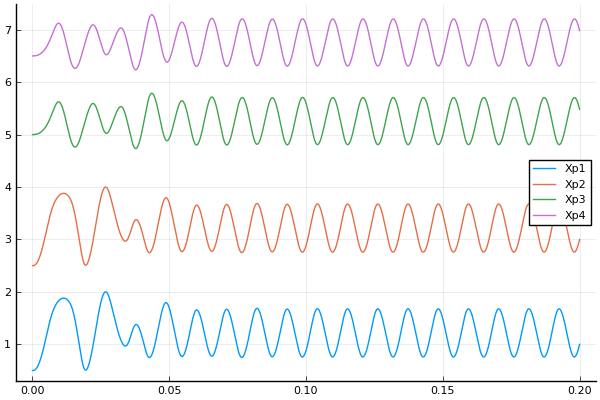

In [99]:
plot(thist,X1hist,label="Xp1")
plot!(thist,X2hist,label="Xp2")
plot!(thist,X3hist,label="Xp3")
plot!(thist,X4hist,label="Xp4")

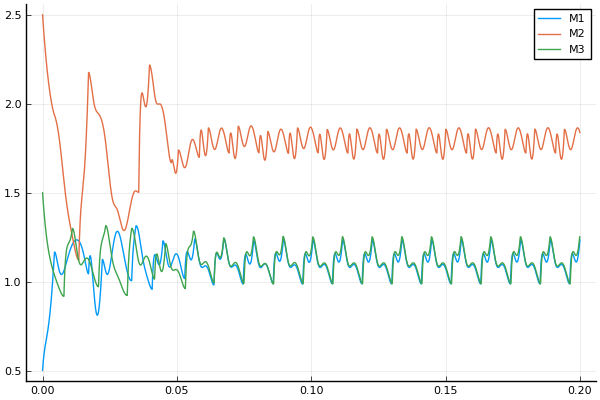

In [100]:
plot(thist,M1hist,label="M1")
plot!(thist,M2hist,label="M2")
plot!(thist,M3hist,label="M3")

In [38]:
sol[100000]

11-element Array{Float64,1}:
  1.0061864012866513  
  3.006186401286641   
  5.89996124111515    
  6.0999612411151505  
 -0.006508896195488061
 -0.006508896195488061
  8.263288807401117e-5
  8.263288807401117e-5
  0.6707513337161944  
  1.9275691371315429  
  1.2656388593558738  

In [19]:
M=sol[end][9:11]

3-element Array{Float64,1}:
 0.6707499868990021
 1.9275703543982021
 1.265638844098699 

In [20]:
dMdtzhang2002model(Xpvapor,θ,sys0)

UndefVarError: UndefVarError: Xpvapor not defined

In [21]:
θ=P.^((γ-1)/γ)

3-element Array{Float64,1}:
 1.0
 1.0
 1.0

In [22]:
Xpvapor=getXpvapor(X0,L)

3-element Array{Tuple{Float64,Float64},1}:
 (0.0, 0.5)
 (2.5, 5.5)
 (5.7, 8.0)

In [23]:
Lcondoverlap=XptoLoverlap(X0,Xc)

2-element Array{Float64,1}:
 1.5                
 0.20000000000000018